# Challenge: Evaluate Your Sentiment Classifier

It's time to revisit your classifier from the previous assignment. Using the evaluation techniques we've covered here, look at your classifier's performance in more detail. Then go back and iterate by engineering new features, removing poor features, or tuning parameters. Repeat this process until you have five different versions of your classifier. Once you've iterated, answer these questions to compare the performance of each:

- Do any of your classifiers seem to overfit?
- Which seem to perform the best? Why?
- Which features seemed to be most impactful to performance?

Write up your iterations and answers to the above questions in a few pages. Submit a link below and go over it with your mentor to see if they have any other ideas on how you could improve your classifier's performance.

In [20]:
import scipy
import sklearn
import string

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.model_selection import KFold
from scipy import stats

plt.style.use("default")
sns.set(style="whitegrid")

In [2]:
# Load the data from imdb_labelled.txt into a pandas dataframe
file_path = "sentiment labelled sentences\imdb_labelled.txt"

imdb_raw = pd.read_csv(file_path, delimiter="\t", header=None)
imdb_raw.columns = ["reviews","sentiment_score"]

In [3]:
# No need to search for word candidates as they were set in the first Challenge assignment
# Words to match on in the data
keywords = ["best", "good", "loved", "very", "perfect", "greatest", "perfect", "10", "decent", "terrific", "fun", "beautiful"]

for key in set(keywords):
    imdb_raw[str(key)] = imdb_raw["reviews"].str.contains(" "+str(key)+" ", case=False)

# Convert the sentiment_score to boolean values
imdb_raw["sentiment_score"] = (imdb_raw["sentiment_score"]==1)

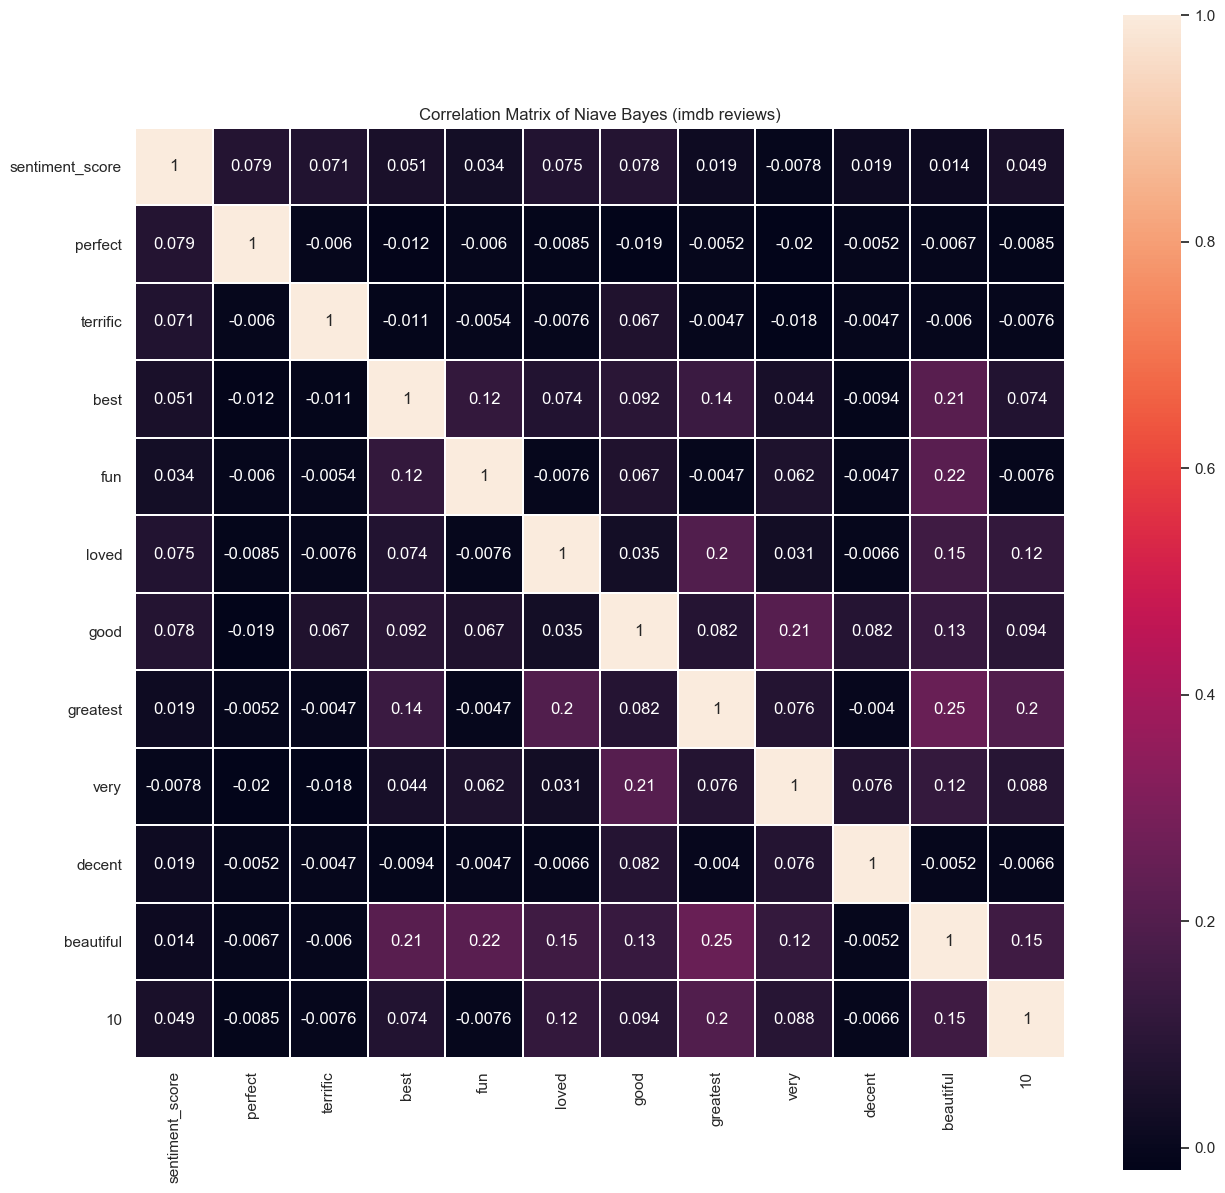

In [4]:
# Visual variable independence 
def corr_plot(corr_mat,figsize,title):
    """
        Pass in a correlation matrix and figsize (as a tuple) and plot the corresponding heatmap.
    """
    plt.figure(figsize=figsize)

    sns.heatmap(corr_mat, square=True, annot=True, linewidth=0.5)
    plt.title(title)

    # Fix display issues for this version of matplotlib
    b,t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b,t)
    # plt.yticks(rotation=360)

    plt.show();

# imdb_raw.dropna(axis=1,how="any",inplace=True)
corr_plot(corr_mat=imdb_raw.corr(),figsize=(15,15),title=f"Correlation Matrix of Niave Bayes (imdb reviews)")

In [23]:
X = imdb_raw[keywords] # x for BernoulliNP.fit()
y = imdb_raw["sentiment_score"] # y for BernoulliNP.fit() 

# Instantiate the model and store in a variable
bnb = BernoulliNB()

# Set the number of folds (training and test samples) 
kf = KFold(n_splits=5)

# Counter for pinting
i=0

# Train and test using the KFolds
for train_index, test_index in kf.split(X):
    # print("TRAIN:", train_index, "TEST:", test_index)
    i+=1
    # Create the train samples from the fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]

    # Create the test samples from the fold
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Locate the appropriate rows in the target series
    target_ref = y.iloc[train_index]

    # Train the model using the train and test data
    y_pred = bnb.fit(X_train, y_train).predict(X_train)

    # Create a Confusion Matrix to report on model training
    confusion_matrix = dict(
        false_positives=((~target_ref)&(y_pred)).sum(),
        false_negatives=((target_ref)&(~y_pred)).sum(),
        y_pred_correct_pos=((target_ref)&(y_pred)).sum(),
        y_pred_correct_neg=((~target_ref)&(~y_pred)).sum(),
        target_pos=(target_ref).sum(),
        target_neg=(~target_ref).sum(),
        sensitivity=(((target_ref)&(y_pred)).sum()/(target_ref).sum())*100,     
        specificity=(((~target_ref)&(~y_pred)).sum()/(~target_ref).sum())*100, 
        total_errors=(target_ref != y_pred).sum()
    )

    

    # Generate a report of model training
    print(f"""Fold {i}:
Total Errors: {confusion_matrix["total_errors"]}, False Negatives: {confusion_matrix["false_negatives"]}, False Positives: {confusion_matrix["false_positives"]}, Sensitivity: {confusion_matrix["sensitivity"]:,.4f}% Specificity: {confusion_matrix["specificity"]:,.4f}%
Testing on Sample: {bnb.fit(X_test, y_test).score(X_test, y_test)}
""")
    

Fold 1:
Total Errors: 263, False Negatives: 9, False Positives: 254, Sensitivity: 97.2644% Specificity: 5.5762%
Testing on Sample: 0.66

Fold 2:
Total Errors: 287, False Negatives: 16, False Positives: 271, Sensitivity: 94.8718% Specificity: 5.2448%
Testing on Sample: 0.6466666666666666

Fold 3:
Total Errors: 272, False Negatives: 3, False Positives: 269, Sensitivity: 99.0881% Specificity: 0.0000%
Testing on Sample: 0.6533333333333333

Fold 4:
Total Errors: 257, False Negatives: 242, False Positives: 15, Sensitivity: 15.9722% Specificity: 95.1768%
Testing on Sample: 0.6577181208053692

Fold 5:
Total Errors: 242, False Negatives: 229, False Positives: 13, Sensitivity: 19.9301% Specificity: 95.8466%
Testing on Sample: 0.6711409395973155

